# Example code to use model_utilities for biomass and carbon data cleaning and chapman-richards curve fitting

To do: 
- show wood density in action
- figure out where to put the ipcc csv so people can access

In [1]:
import model_utilities #not needed, just checking if it works
import pandas as pd
import numpy as np

In [2]:
# import os
# local_path = '/Users/anikastaccone/Documents/earthshot/github_repos/'
# dir_path = 'science/Ad-hoc_project_analyses/Synthesis and automation'
# os.chdir(local_path + dir_path)

# Illustrate curve fit with (bounded) free p parameter

In [3]:
test_df = pd.DataFrame({'age': [1,2,3,4,5],
                       'agb_t_ha':[8,15,20,21,22],
                       'bgb_t_ha':[np.nan,np.nan,10,7,np.nan],
                       'agb_bgb_t_ha':[np.nan,np.nan,np.nan,np.nan,np.nan],
                       'source':['paper1','paper2','paper3','paper4','paper5']})
test_df

,age,agb_t_ha,bgb_t_ha,agb_bgb_t_ha,source
0,1,8,NaN,NaN,paper1
1,2,15,NaN,NaN,paper2
2,3,20,10.0,NaN,paper3
3,4,21,7.0,NaN,paper4
4,5,22,NaN,NaN,paper5


In [4]:
from model_utilities.forest_mensuration import clean_biomass_data

In [5]:
clean_df = clean_biomass_data(test_df, d_type='biomass')
clean_df

,age,agb_t_ha,bgb_t_ha,agb_bgb_t_ha,source,agb_tCO2e_ha,bgb_tCO2e_ha,agb_bgb_tCO2e_ha
0,1,8,2.280,10.280,paper1,13.786667,3.929200,17.715867
1,2,15,4.275,19.275,paper2,25.850000,7.367250,33.217250
2,3,20,10.000,30.000,paper3,34.466667,17.233333,51.700000
3,4,21,7.000,28.000,paper4,36.190000,12.063333,48.253333
4,5,22,6.270,28.270,paper5,37.913333,10.805300,48.718633


Add IPCC points to literature data

In [8]:
from model_utilities import ipcc_tier_1

In [9]:
ipcc_natural = ipcc_tier_1.PredictIPCC(polygonData=None,
            ecozone='tropical dry forest',
            continent='south america',
            forest_type='natural',
            yearStart = 0,
            yearEnd = 30)

ipcc_natural_mid = ipcc_natural['predictions']['natural']['biomass']

ipcc_time = np.arange(0, len(ipcc_natural_mid), 1)

ipcc_plantation = ipcc_tier_1.PredictIPCC(polygonData=None,
            ecozone='tropical dry forest',
            continent='south america',
            forest_type='other broadleaf',
            yearStart = 0,
            yearEnd = 30)

ipcc_plantation_mid = ipcc_plantation['predictions']['other broadleaf']['biomass']



# take mean of natural and other broadleaf plantation
ipcc_pts = np.mean([ipcc_natural_mid[[10,20,30]], 
                    ipcc_plantation_mid[[10,20,30]]
                   ], axis=0)
ipcc_pts = pd.DataFrame({'age':[10,20,30],
                       'agb_bgb_tCO2e_ha':ipcc_pts,
                        'source':['ipcc','ipcc','ipcc']})



In [10]:
#from model_utilities.curve_fitting.curve_fitting import GrowthCurveFit
from model_utilities.curve_fitting import GrowthCurveFit

Initialize GrowthCurveFit object with growth data

In [26]:
growth_curve_fit = GrowthCurveFit(growth_df=test_df)

Create artificial array of maximum biomasses

In [27]:
max_biomass = pd.DataFrame({
    'Source':['Some mature biomass resource', 'Some mature biomass resource', 'Some mature biomass resource'],
    'Detail':['p70', 'p80', 'p90'],
    'agb_bgb_tCO2e_ha':[60, 70, 80]
})

max_biomass

,Source,Detail,agb_bgb_tCO2e_ha
0,Some mature biomass resource,p70,60
1,Some mature biomass resource,p80,70
2,Some mature biomass resource,p90,80


Set the max_df variable in the class

In [28]:
growth_curve_fit.set_maxes(max_df=max_biomass)

Do a curve fit for each max biomass

In [29]:
growth_curve_fit.fit_curve(curve_formula='chapman_richards_set_ymax',
                           curve_fit_params=None,
                           set_params=None)

/Users/anikastaccone/opt/anaconda3/envs/spatial-env/lib/python3.9/site-packages/model_utilities/curve_formulas.py:22: RuntimeWarning: invalid value encountered in power
  y = x[: ,1] * np.power( (1 - np.exp(-k * x[: ,0])), p)


In [30]:
growth_curve_fit.params

[array([0.50953368, 1.24697056]),
 array([0.27132301, 0.84249871]),
 array([0.17522833, 0.71506713])]

In [31]:
growth_curve_fit.covars

[array([[0.03211998, 0.0994391 ],
        [0.0994391 , 0.35060642]]),
 array([[0.01456341, 0.04362898],
        [0.04362898, 0.14428848]]),
 array([[0.00853847, 0.02763513],
        [0.02763513, 0.09641528]])]

Looks like it works; could be nice to have convenience functions to "get" these attributes. The next steps are a method to do the predictions (I guess these get stored in their own dataframe), Monte Carlo uncertainties (these are like predictions and may use the prediction function, just with other parameters... should results be stored in a dataframe and should they be all the ensemble members? I think so, yes), and then, in a separate module for plotting, a plotting function that can take the optimal estimates, and the MC ensembles, 

In [32]:
growth_curve_fit.predictions_with_monte_carlo(years_predict=100, n_mc=500)

/Users/anikastaccone/opt/anaconda3/envs/spatial-env/lib/python3.9/site-packages/model_utilities/curve_formulas.py:22: RuntimeWarning: invalid value encountered in power
  y = x[: ,1] * np.power( (1 - np.exp(-k * x[: ,0])), p)
/Users/anikastaccone/opt/anaconda3/envs/spatial-env/lib/python3.9/site-packages/model_utilities/curve_formulas.py:22: RuntimeWarning: invalid value encountered in power
  y = x[: ,1] * np.power( (1 - np.exp(-k * x[: ,0])), p)


In [33]:
growth_curve_fit.prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               100 non-null    int64  
 1   Some mature biomass resource_p70  100 non-null    float64
 2   Some mature biomass resource_p80  100 non-null    float64
 3   Some mature biomass resource_p90  100 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 3.2 KB


In [34]:
growth_curve_fit.prediction_df

,Age,Some mature biomass resource_p70,Some mature biomass resource_p80,Some mature biomass resource_p90
0,1,19.093282,20.859090,21.647361
1,2,34.330069,33.622645,33.469056
2,3,44.237113,42.748252,42.201894
3,4,50.415552,49.462940,49.003434
4,5,54.202173,54.468408,54.431958
...,...,...,...,...
95,96,60.000000,70.000000,79.999997
96,97,60.000000,70.000000,79.999998
97,98,60.000000,70.000000,79.999998
98,99,60.000000,70.000000,79.999998


In [35]:
growth_curve_fit.monte_carlo_dfs.keys()

dict_keys(['Some mature biomass resource_p70', 'Some mature biomass resource_p80', 'Some mature biomass resource_p90'])

In [36]:
growth_curve_fit.monte_carlo_dfs['Some mature biomass resource_p70'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 500 entries, sim_0 to sim_499
dtypes: float64(500)
memory usage: 390.8 KB


In [37]:
growth_curve_fit.monte_carlo_dfs['Some mature biomass resource_p70'].head()

,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
0,23.775102,17.159417,26.800972,22.422357,15.280836,15.708442,14.423937,12.370978,18.614653,53.282853,...,34.633485,23.410237,14.563612,16.390086,25.805199,19.991520,16.756274,19.347580,18.271322,18.398523
1,38.532668,31.431137,38.584246,38.246793,31.995083,32.166519,37.413024,27.994999,35.647565,54.976095,...,42.468225,37.536031,28.110863,29.649545,40.796132,34.399495,30.317053,35.465245,34.733302,35.498782
2,47.330331,41.299306,45.801231,47.641085,43.410288,43.363406,50.431848,39.737324,46.295450,55.944651,...,47.168271,46.188229,38.117615,39.123197,49.248261,43.784034,39.890797,45.642113,45.283385,46.222594
3,52.535996,47.866197,50.466572,53.034680,50.416554,50.279530,56.169697,47.531909,52.435002,56.610122,...,50.353372,51.502383,45.149742,45.721321,53.988215,49.776246,46.462673,51.711284,51.574130,52.406317
4,55.606798,52.164856,53.554215,56.089998,54.533725,54.385821,58.498880,52.443130,55.863110,57.107578,...,52.634199,54.770088,49.984828,50.265504,56.640680,53.570236,50.919017,55.247625,55.217079,55.855151


Get confidence interval around curve

In [39]:
from model_utilities.curve_fitting import GrowthCurveFit
from model_utilities.visualization import plotting_ensemble
from model_utilities.visualization import plotting_maxs
from model_utilities.curve_fitting import ensemble_ci
from model_utilities.curve_fitting import extract_ensemble_member

In [41]:
ensemble_bounded = ensemble_ci(growth_curve_fit)

Plot the entire ensemble of curves

<module 'matplotlib.pyplot' from '/Users/anikastaccone/opt/anaconda3/envs/spatial-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

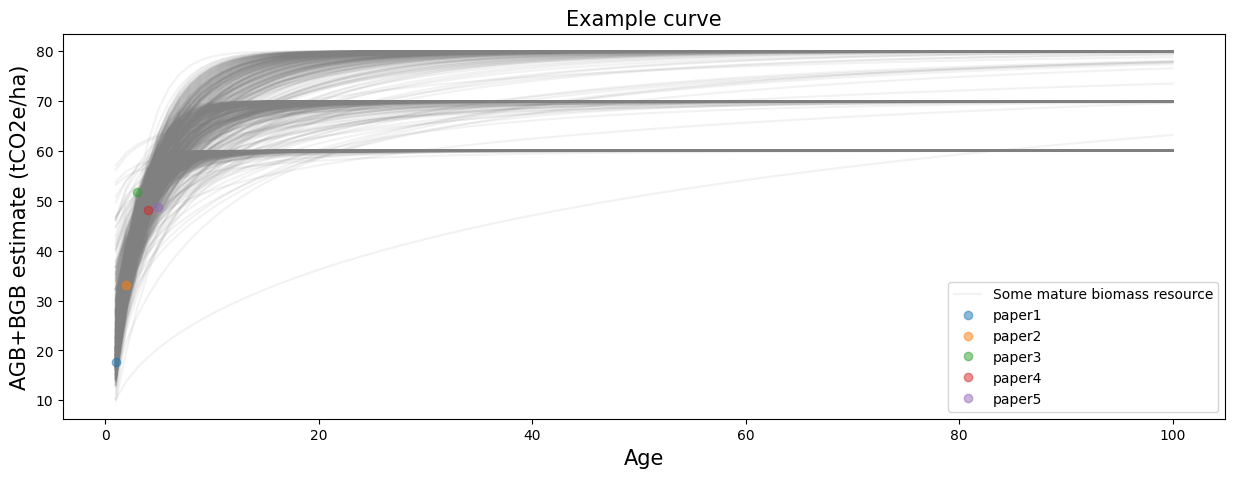

In [42]:
plotting_ensemble(growth_curve_fit, 'Example curve', 100, True)

Plot just the single curve for each maximum

<module 'matplotlib.pyplot' from '/Users/anikastaccone/opt/anaconda3/envs/spatial-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

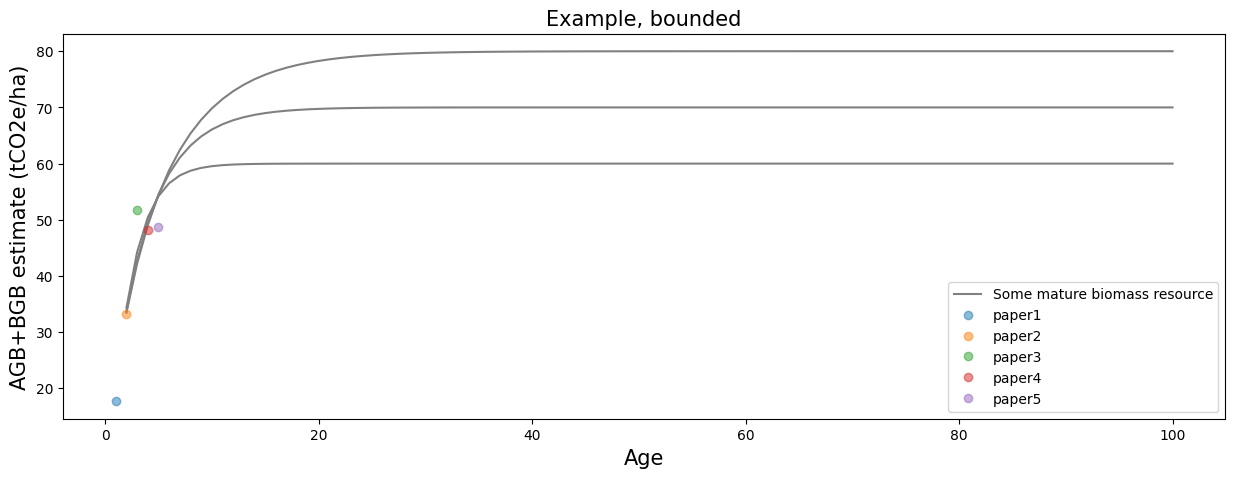

In [43]:
plotting_maxs(growth_curve_fit, 'Example, bounded', 100, True)

Extract an ensemble member that most closely matches the given percentile

In [45]:
mod_scenario = extract_ensemble_member(growth_curve_fit, ensemble_bounded, 0.5)
mod_scenario

0     35.511441
1     44.335845
2     49.922842
3     53.913123
4     56.925031
        ...    
95    69.999997
96    69.999998
97    69.999998
98    69.999998
99    69.999998
Name: 501, Length: 100, dtype: float64

# With set p

In [18]:
growth_curve_fit_p = GrowthCurveFit(growth_df=test_df)
growth_curve_fit_p.set_maxes(max_df=max_biomass)
growth_curve_fit_p.fit_curve(curve_formula='chapman_richards_set_ymax_and_p',
                           curve_fit_params=None,
                           set_params={'p':3})

In [19]:
growth_curve_fit_p.params

[array([0.88037625]), array([0.67474268]), array([0.55062423])]

In [20]:
growth_curve_fit_p.covars

[array([[0.01057887]]), array([[0.00909217]]), array([[0.00656257]])]

In [21]:
growth_curve_fit_p.predictions_with_monte_carlo(years_predict=100, n_mc=500)

In [26]:
growth_curve_fit_p.prediction_df

,Age,Some mature biomass resource_p70,Some mature biomass resource_p80,Some mature biomass resource_p90
0,1,12.035097,8.271410,6.072591
1,2,34.070248,28.437762,23.797434
2,3,48.062302,45.762890,42.249627
3,4,54.835794,56.801432,56.297426
4,5,57.821152,63.048647,65.659141
...,...,...,...,...
95,96,60.000000,70.000000,80.000000
96,97,60.000000,70.000000,80.000000
97,98,60.000000,70.000000,80.000000
98,99,60.000000,70.000000,80.000000
